In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from abc import ABC

class AbstractArm(ABC):
    
    def pull(self, n):
        pass
    
    def get_mean(self):
        return self.mu

class BernoulliArm(AbstractArm):
    
    def __init__(self, mu):
        self.mu = mu
    
    def pull(self, n):
        return np.random.rand(n) < self.mu

    
class Bandit:

    def __init__(self, arms):
        self.arms = arms
        self.num_arms = len(arms)
        
        self.opt_arm = np.argmax([arm.get_mean() for arm in arms])
        self.opt_arm_mean = arms[self.opt_arm].get_mean()
        
    def get_opt_arm(self):
        return self.opt_arm
    
    def get_opt_arm_mean(self):
        return self.opt_arm_mean
        
    def get_num_arms(self):
        return self.num_arms
    
    def pull_arm(self, i, n):
        return self.arms[i].pull(n)
    
    def pull_all_arms(self, n):
        results = np.zeros((self.num_arms, n))
    
        for i in range(self.num_arms):
            results[i] = self.pull_arm(i, n)
            
        return results

In [3]:
def test_BernoulliBandit():
    
    b1 = BernoulliArm(0.5)
    b2 = BernoulliArm(0.2)
    b3 = BernoulliArm(0.8)
    
    print(b1.pull(10))
    print(b2.pull(10))
    print(b3.pull(10))
    
    print()
    b5 = Bandit([b1, b2, b3])
    print(b5.pull_arm(0, 10))
    print(b5.pull_arm(1, 10))
    print(b5.pull_arm(2, 10))
    print(b5.pull_all_arms(10))
    
test_BernoulliBandit()

[ True  True False False  True  True  True False  True False]
[False False  True False False False False  True  True False]
[ True False False False False  True False False  True  True]

[ True  True False  True False  True False  True  True False]
[ True False False  True  True False False False False False]
[False  True  True  True  True  True False False  True  True]
[[0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]]


In [4]:
def ETC(bandit, n, m):
    '''
    k arms, Bernoulli bandits
    n horizon
    m number of pulls for each arm in exploration phase
    '''
    k = bandit.get_num_arms()
    
    explore_reward_totals = np.zeros(k)
    
    # Explore phase
    explore_rewards = bandit.pull_all_arms(m)
    explore_reward_totals = [np.sum(explore_rewards[i]) for i in range(k)]
    
    # np.argmax does not randomize over ties, so we use np.random.choice
    # np.flatnonzero returns the indices of nonzero elements in a (flattened) array.
    best_arm = np.random.choice(np.flatnonzero(explore_reward_totals == np.max(explore_reward_totals)))
    
    # Commit phase
    commit_rewards = bandit.pull_arm(best_arm, n-m*k)
    
    explore_rewards_flattened = explore_rewards.ravel()
    all_rewards = np.concatenate((explore_rewards_flattened, commit_rewards), axis=0)
    
    return all_rewards
     
def test_ETC():
    b0 = BernoulliArm(0.2)
    b1 = BernoulliArm(0.5)
    b2 = BernoulliArm(0.8)
    arms = [b0, b1, b2]
    bandit = Bandit(arms)
    ETC(bandit, 100, 10)

In [5]:
# Note that Bernoulli(mu) is 1/4-subgaussian, and the average is sqrt(1/(4m))-sg
# So the upper bound on the probability is 
# exp(-n*eps^2/(2*sigma^2) = exp(-n*Delta^2/)

def compute_cumulative_regret(bandit, rewards):
    mu_opt = bandit.get_opt_arm_mean()
    regrets = [mu_opt - rewards[i] for i in range(len(rewards))]
    return np.cumsum(regrets)
    
def ETC_expected_regret(n, num_trials):
    mu0 = 0.5
    mu1 = 0.2
    arms = [BernoulliArm(mu0), BernoulliArm(mu1)]
    bandit = Bandit(arms)
    
    Delta = abs(mu0 - mu1)
    m = int(np.max([1, np.ceil(1/Delta**2 * np.log(n*Delta**2))]))
    
    all_rewards = np.zeros((num_trials, n))
    
    for t in range(num_trials):
        rewards = ETC(bandit, n, m)
        all_rewards[t] = rewards
     
    expected_rewards = np.sum(all_rewards, axis=0)/num_trials
    
    return compute_cumulative_regret(bandit, expected_rewards)

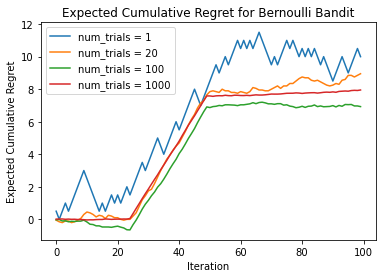

In [6]:
def plot_expected_regret_ETC():
    
    num_trials_vec = [1, 20, 100, 1000]
    
    for num_trials in num_trials_vec:
        expected_regret = ETC_expected_regret(100, num_trials)
        plt.plot(expected_regret, label='num_trials = ' + str(num_trials))
        
    plt.title('Expected Cumulative Regret for Bernoulli Bandit')
    plt.ylabel('Expected Cumulative Regret')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
    
plot_expected_regret_ETC()

In [17]:
N = 100 # number of mu values for arm 1
n = 1000 # number of iterations for each mu setting

mu0 = 0.5
b1_mus = np.linspace(0, 0.5, N+1)[:N]
Deltas = mu0-b1_mus

expected_regrets = np.zeros(N)

for i in range(N):
    
    mu1 = b1_mus[i]
    arms = [BernoulliArm(mu0), BernoulliArm(mu1)]
    bandit = Bandit(arms)

    Delta = Deltas[i]
    
    for j in range(n):
    
        m = int(np.max([1, np.ceil(1/Delta**2 * np.log(n*Delta**2))]))
        expected_regrets[i] += np.sum(ETC(bandit, n, m))/n


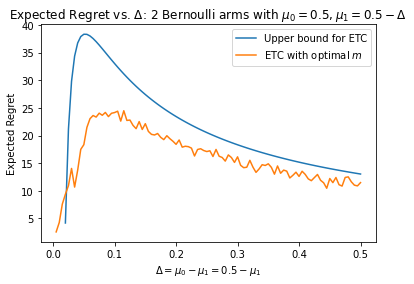

In [24]:
max_arg_1 = n*Deltas
max_arg_2 = 1/Deltas*(1 + np.log(n*Deltas**2))
upper_bound = [np.min([max_arg_1[i], max_arg_2[i]]) for i in range(N)]

plt.plot(Deltas[:N-3], upper_bound[:N-3], label='Upper bound for ETC')
plt.plot(Deltas, n*0.5-expected_regrets, label='ETC with optimal $m$')
plt.ylabel('Expected Regret')
plt.xlabel('$\Delta = \mu_0 - \mu_1 = 0.5 - \mu_1$')
plt.title('Expected Regret vs. $\Delta$: 2 Bernoulli arms with $\mu_0 = 0.5, \mu_1 = 0.5 - \Delta$')
plt.legend()
plt.show()

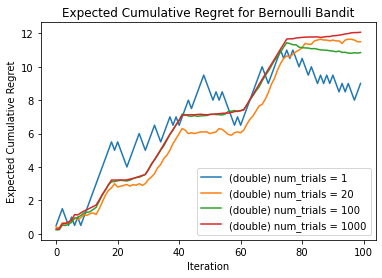

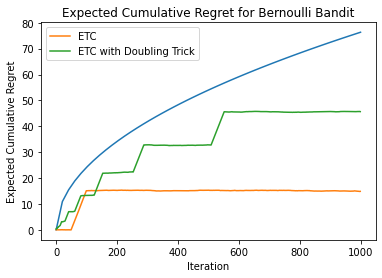

In [29]:
# Doubling trick 
def ETC_double(bandit, n):
    

    mu_opt = bandit.get_opt_arm_mean()
    Delta = mu_opt - 0.2

    num_phases = int(np.ceil(np.log2(n)))
    phase_lengths = [2**i for i in range(1, num_phases)]
    
    # Make sure the total number of trials across phases
    # does not exceed n by adjust the length of the final
    # phase.
    extra = np.sum(phase_lengths) - n
    phase_lengths[-1] -= extra
    
    phase_rewards = []
    phase_regrets = []

    for i in range(num_phases-1):

        ni = phase_lengths[i]

        Delta = 0.5 - 0.2
        mi = int(np.max([1, np.ceil(1/Delta**2 * np.log(ni*Delta**2))]))

        rewards = ETC(bandit, ni, mi)
        phase_rewards.append(rewards)

    all_rewards = np.concatenate(phase_rewards).ravel()
    
    return all_rewards

def ETC_double_expected_regret(n, num_trials):
    
    all_rewards = np.zeros((num_trials, n))
    for t in range(num_trials):
        rewards = ETC_double(bandit, n)
        all_rewards[t] = rewards
     
    expected_rewards = np.sum(all_rewards, axis=0)/num_trials
    
    return compute_cumulative_regret(bandit, expected_rewards)


def plot_expected_regret_ETC_double():
    
    num_trials_vec = [1, 20, 100, 1000]
        
    for num_trials in num_trials_vec:
        expected_regret_double = ETC_double_expected_regret(100, num_trials)
        plt.plot(expected_regret_double, label='(double) num_trials = ' + str(num_trials))
        
    plt.title('Expected Cumulative Regret for Bernoulli Bandit')
    plt.ylabel('Expected Cumulative Regret')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
    

    expected_regret = ETC_expected_regret(1000, 1000)
    expected_regret_double = ETC_double_expected_regret(1000, 1000)
    
    x = np.linspace(0,1000)
    c1 = 1+1/np.e
    c2 = 2*(1 + np.sqrt(2))/2
    plt.plot(x, c2*np.sqrt(x))
    
    plt.plot(expected_regret, label='ETC')
    plt.plot(expected_regret_double, label='ETC with Doubling Trick')
    plt.title('Expected Cumulative Regret for Bernoulli Bandit')
    plt.ylabel('Expected Cumulative Regret')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()
    

    
b0 = BernoulliArm(0.2)
b1 = BernoulliArm(0.5)
arms = [b0, b1]
bandit = Bandit(arms)
n = 1000

plot_expected_regret_ETC_double()

# note that it's possible for empirical expected regret to decrease, since
# the expectation is a sampled average.

TODO
* Fix upper bound so it takes the max of 0 and log term
* Show Bernoulli is 1/4-subgaussian
* Overview of ETC and analysis
<!-- * Why is the upper bound so bad when $\Delta$ is small, e.g. $\Delta \approx 0.05$? Mathematically, it's because of the division by $\Delta$. But why intuitively? -->
* greedy 6.7

Limitations
* Depends on advance knowledge of suboptimality gaps of each arm